# SAM3 远程无 GUI 两阶段分割（机械臂 + gripper 新 obj_id）

本 notebook 面向远程服务器（无 GUI）逐 cell 交互执行：

- 阶段 A：先做一次普通传播（bootstrap）填充缓存，再进行机械臂 points/labels refinement。
- 阶段 B：必须在关键帧注入 gripper 独立对象（左右 obj_id），并进行双向传播。
- 导出固定为 arm-only：使用 Stage B 的 gripper obj_id 掩码执行扣除 `arm_only = arm_mask AND NOT gripper_mask`。


In [2]:
import os
import glob
import json
from pathlib import Path

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

import sam3
from sam3.model_builder import build_sam3_video_predictor
from sam3.visualization_utils import prepare_masks_for_visualization, visualize_formatted_frame_output

# 工具函数（校验 / 坐标转换 / 推理流程 / 导出 / 清理）

from mask_pipeline_tools import (
    cleanup_process_group,
    cleanup_resources,
    load_video_frames_for_visualization,
    get_frame_size,
    abs_to_rel_points,
    validate_prompt_entry,
    normalize_prompt_entry,
    validate_and_normalize_prompt_list,
    validate_obj_id_constraints,
    propagate_in_video,
    propagate_bidirectional_and_merge,
    add_point_prompt,
    apply_prompt_list,
    add_text_prompt,
    visualize_outputs,
    save_arm_only_masks_for_propainter,
    sample_obj_ids_from_outputs,
    collect_present_obj_ids,
    diagnose_gripper_prompt_side_consistency,
)

from annotation_ui_tools import (
    load_annotation_prompts_json,
    validate_export_prompt_map,
    summarize_prompt_map,
)

plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12

# ==============================
# 关键配置区（建议仅修改本区）
# ==============================

# 1) 路径配置
VIDEO_PATH = "/data/haoxiang/data/airexo2/task_0013/train/scene_0001/cam_105422061350/color"
CHECKPOINT_PATH = "/data/haoxiang/sam3/models/facebook/sam3/sam3.pt"

# 2) 推理配置
CUDA_VISIBLE_DEVICES = "0,1,2,3"
APPLY_TEMPORAL_DISAMBIGUATION = False
PROPAGATION_DIRECTION_STAGE_A = "forward"  # 建议 forward
PROPAGATION_DIRECTION_STAGE_B = "forward"  # 关键帧新增对象后再 forward

# 3) 对象 ID 配置（单 arm+cable + 左右 gripper，三者必须互不重复）
arm_cable_obj_id = 0
gripper_left_obj_id = 2
gripper_right_obj_id = 3

# 4) 阶段 A：arm+cable bootstrap 文本提示（固定）
# 为避免首次 points add_prompt 触发 cached outputs 断言，需先完成一次普通传播
ARM_CABLE_BOOTSTRAP_TEXT_PROMPT = "robot and cable"
ARM_CABLE_BOOTSTRAP_FRAME_INDEX = None

# 5) 阶段 A：arm+cable points refinement（可为空）
# coord_type: "abs"(像素坐标) / "rel"([0,1]归一化坐标)
ARM_CABLE_INITIAL_PROMPTS = [
    {
        "frame_index": 120,
        "obj_id": 0,
        "coord_type": "abs",
        "points": [[962, 350]],
        "labels": [0],
    }
]

# 6) 阶段 B：关键帧新增左右 gripper（points + point_labels + 新 obj_id）
# 支持多关键帧，左右 obj_id 可独立配置
GRIPPER_LEFT_KEYFRAME_PROMPTS = [
    {
        "frame_index": 120,
        "obj_id": 2,
        "coord_type": "abs",
        "points": [[973, 356], [930, 330]],
        "labels": [1, 0],
    }
]

GRIPPER_RIGHT_KEYFRAME_PROMPTS = []

# 6.1) Stage B gripper 固定 points-only（禁止文本提示路径）
STAGE_B_GRIPPER_POINTS_ONLY = True
GRIPPER_LEFT_KEYFRAME_TEXT_PROMPT = ""
GRIPPER_RIGHT_KEYFRAME_TEXT_PROMPT = ""

# 6.5) 数据来源策略（JSON-only）
# Stage A/B 只允许从 JSON 读取 prompts，不允许内存回退。
USE_VISUAL_ANNOTATION_EXPORT = True
ANNOTATION_EXPORT_PROMPTS = None

# 6.6) 标注 JSON 持久化配置（强制 JSON 读取）
ANNOTATION_EXPORT_JSON_PATH = str(Path(VIDEO_PATH).resolve().parent / "annotation_prompts_gripper_points.json")
LOAD_ANNOTATION_PROMPTS_FROM_JSON = True
SAVE_ANNOTATION_PROMPTS_TO_JSON = True

# 7) 可视化配置
VIS_FRAME_STRIDE = 60
VIS_MAX_PLOTS = 8

# 8) 导出配置（固定 arm-only）
EXPORT_OUTPUT_DIR = "/data/haoxiang/propainter/masks_airexo_arm_only"
EXPORT_DILATE_RADIUS = 15
EXPORT_LOG_EVERY = 50

# 运行时变量（无需手动修改）
predictor = None
session_id = None
video_frames_for_vis = None
TOTAL_FRAMES = None
IMG_WIDTH = None
IMG_HEIGHT = None
arm_cable_prompts_norm = None
gripper_left_prompts_norm = None
gripper_right_prompts_norm = None
outputs_stage_a = None
outputs_stage_b = None
ANNOTATION_PROMPTS_SOURCE = "json_required"
ANNOTATION_PROMPTS_CREATED_AT_UTC = None


/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 1) 载入可视化帧 + 校验配置 + 初始化 predictor/session

In [3]:
# 载入可视化帧 + 校验配置 + 初始化 predictor/session

# Notebook 反复执行时，先清理旧资源，避免 NCCL 初始化异常
if "predictor" in globals() and predictor is not None:
    print("[init] cleaning previous predictor/session before re-run")
    cleanup_resources(predictor_obj=predictor, session_id_value=session_id)

os.environ["CUDA_VISIBLE_DEVICES"] = CUDA_VISIBLE_DEVICES
print(f"[init] CUDA_VISIBLE_DEVICES={os.environ.get('CUDA_VISIBLE_DEVICES')}")

video_frames_for_vis = load_video_frames_for_visualization(VIDEO_PATH)
TOTAL_FRAMES = len(video_frames_for_vis)
IMG_WIDTH, IMG_HEIGHT = get_frame_size(video_frames_for_vis)
print(f"[init] loaded frames={TOTAL_FRAMES}, size={IMG_WIDTH}x{IMG_HEIGHT}")

if not LOAD_ANNOTATION_PROMPTS_FROM_JSON:
    raise ValueError(
        "[annotation][fatal] 当前 notebook 已配置为仅允许 JSON 读取。"
        "请将 LOAD_ANNOTATION_PROMPTS_FROM_JSON 设为 True。"
    )

USE_VISUAL_ANNOTATION_EXPORT = True
print(f"[annotation] loading prompts from JSON (JSON-only mode): {ANNOTATION_EXPORT_JSON_PATH}")
try:
    with open(ANNOTATION_EXPORT_JSON_PATH, "r", encoding="utf-8") as _f:
        _annotation_json_payload = json.load(_f)
    ANNOTATION_PROMPTS_CREATED_AT_UTC = (
        _annotation_json_payload.get("created_at_utc")
        if isinstance(_annotation_json_payload, dict)
        else None
    )
    ANNOTATION_EXPORT_PROMPTS = load_annotation_prompts_json(
        json_path=ANNOTATION_EXPORT_JSON_PATH,
        status_prefix="[annotation]",
    )
    ANNOTATION_PROMPTS_SOURCE = "json"
except Exception as e:
    raise RuntimeError(
        "[annotation][fatal] 读取标注 JSON 失败，已阻断流程；"
        "请确认先完成导出，并检查 ANNOTATION_EXPORT_JSON_PATH 与 JSON 格式。"
    ) from e

ARM_CABLE_INITIAL_PROMPTS = ANNOTATION_EXPORT_PROMPTS["ARM_CABLE_INITIAL_PROMPTS"]
GRIPPER_LEFT_KEYFRAME_PROMPTS = ANNOTATION_EXPORT_PROMPTS["GRIPPER_LEFT_KEYFRAME_PROMPTS"]
GRIPPER_RIGHT_KEYFRAME_PROMPTS = ANNOTATION_EXPORT_PROMPTS["GRIPPER_RIGHT_KEYFRAME_PROMPTS"]
print("[annotation] Stage A/B prompts 已由 JSON 导出结果覆盖（JSON-only）")
print(
    f"[annotation][source] source={ANNOTATION_PROMPTS_SOURCE} json_path={ANNOTATION_EXPORT_JSON_PATH} "
    f"created_at_utc={ANNOTATION_PROMPTS_CREATED_AT_UTC}"
)

arm_cable_prompts_norm = validate_and_normalize_prompt_list(
    ARM_CABLE_INITIAL_PROMPTS,
    total_frames=TOTAL_FRAMES,
    img_w=IMG_WIDTH,
    img_h=IMG_HEIGHT,
    tag="ARM_CABLE_INITIAL_PROMPTS",
    allow_empty=True,
)

gripper_left_prompts_norm = validate_and_normalize_prompt_list(
    GRIPPER_LEFT_KEYFRAME_PROMPTS,
    total_frames=TOTAL_FRAMES,
    img_w=IMG_WIDTH,
    img_h=IMG_HEIGHT,
    tag="GRIPPER_LEFT_KEYFRAME_PROMPTS",
    allow_empty=True,
)

gripper_right_prompts_norm = validate_and_normalize_prompt_list(
    GRIPPER_RIGHT_KEYFRAME_PROMPTS,
    total_frames=TOTAL_FRAMES,
    img_w=IMG_WIDTH,
    img_h=IMG_HEIGHT,
    tag="GRIPPER_RIGHT_KEYFRAME_PROMPTS",
    allow_empty=True,
)

validate_obj_id_constraints(
    arm_cable_obj_id=arm_cable_obj_id,
    gripper_left_obj_id=gripper_left_obj_id,
    gripper_right_obj_id=gripper_right_obj_id,
    arm_cable_prompts=arm_cable_prompts_norm,
    gripper_left_prompts=gripper_left_prompts_norm,
    gripper_right_prompts=gripper_right_prompts_norm,
)

print("[init] prompt validation passed")
print(
    f"[init] ARM_CABLE prompt count={len(arm_cable_prompts_norm)} | "
    f"GRIPPER prompt count: left={len(gripper_left_prompts_norm)}, right={len(gripper_right_prompts_norm)}"
)
print(
    f"[init] configured object IDs: arm_cable={arm_cable_obj_id}, "
    f"grippers={[gripper_left_obj_id, gripper_right_obj_id]}"
)

gpus_to_use = range(torch.cuda.device_count())
predictor = build_sam3_video_predictor(
    checkpoint_path=CHECKPOINT_PATH,
    gpus_to_use=gpus_to_use,
    apply_temporal_disambiguation=APPLY_TEMPORAL_DISAMBIGUATION,
)

start_response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=VIDEO_PATH,
    )
)
session_id = start_response["session_id"]
print(f"[init] session started: {session_id}")


[init] CUDA_VISIBLE_DEVICES=0,1,2,3


INFO 2026-02-26 13:32:38,073 2990905 sam3_video_predictor.py: 300: using the following GPU IDs: [0, 1, 2, 3]
INFO 2026-02-26 13:32:38,076 2990905 sam3_video_predictor.py: 316: 


	*** START loading model on all ranks ***


INFO 2026-02-26 13:32:38,077 2990905 sam3_video_predictor.py: 318: loading model on rank=0 with world_size=4 -- this could take a while ...


[init] loaded frames=353, size=1280x720
[annotation] loading prompts from JSON (JSON-only mode): /data/haoxiang/data/airexo2/task_0013/train/scene_0001/cam_105422061350/annotation_prompts_gripper_points.json
[annotation] JSON 读取成功: /data/haoxiang/data/airexo2/task_0013/train/scene_0001/cam_105422061350/annotation_prompts_gripper_points.json
[annotation] JSON created_at_utc: 2026-02-26T05:23:42.868444+00:00
[annotation] 对象条目统计: {'ARM_CABLE_INITIAL_PROMPTS': 0, 'GRIPPER_LEFT_KEYFRAME_PROMPTS': 2, 'GRIPPER_RIGHT_KEYFRAME_PROMPTS': 2}
[annotation] 对象点数统计: {'ARM_CABLE_INITIAL_PROMPTS': 0, 'GRIPPER_LEFT_KEYFRAME_PROMPTS': 2, 'GRIPPER_RIGHT_KEYFRAME_PROMPTS': 2}
[annotation] 按对象逐帧点数统计: {'ARM_CABLE_INITIAL_PROMPTS': {}, 'GRIPPER_LEFT_KEYFRAME_PROMPTS': {0: 1, 120: 1}, 'GRIPPER_RIGHT_KEYFRAME_PROMPTS': {0: 1, 120: 1}}
[annotation] 含标注帧数: 2
[annotation] Stage A/B prompts 已由 JSON 导出结果覆盖（JSON-only）
[annotation][source] source=json json_path=/data/haoxiang/data/airexo2/task_0013/train/scene_0001/ca

INFO 2026-02-26 13:32:47,268 2990905 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-26 13:32:51,201 2990905 sam3_video_predictor.py: 320: loading model on rank=0 with world_size=4 -- DONE locally
INFO 2026-02-26 13:32:51,202 2990905 sam3_video_predictor.py: 377: spawning 3 worker processes
/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/haoxiang/sam3/sam3/model_builder.py

[init] session started: 0724df0f-e753-41fc-b80e-36ff5f0b93f9


## 1.5) 可视化点标注（解耦采集，不触发推理）

最小使用说明：
1. 先运行 `1) 初始化`（上一段 code cell，确保已加载 `video_frames_for_vis` / `TOTAL_FRAMES`）。
2. 运行下方可视化标注 cell：
   - `Frame` 选择标注帧；
   - `Object` 选择对象（左臂/右臂/左夹爪/右夹爪）；
   - `Point Label` 选择 positive(1) / negative(0)；
   - 在图上点击添加点；
   - `Clear Current Obj@Frame` 清空当前对象在当前帧的点。
3. 点击 `Export Prompts` 后会同时：
   - 更新 `ANNOTATION_EXPORT_PROMPTS`（内存变量，兼容旧链路）；
   - 在 `ANNOTATION_EXPORT_JSON_PATH` 落盘 JSON（供后续 Stage A/B 显式读取）。
4. 继续运行初始化 cell：当 `USE_VISUAL_ANNOTATION_EXPORT=True` 且 `LOAD_ANNOTATION_PROMPTS_FROM_JSON=True` 时，
   会优先从 JSON 读取并覆盖四组 prompts；若文件缺失/格式错误会直接报错中止，避免静默使用旧内存数据。


In [ ]:
# 可视化标注：在消费坐标前，先做可见点选并导出为 *_PROMPTS 兼容结构
import json
import traceback

ANNOTATION_MANUAL_TEMPLATE = {
    "ARM_CABLE_INITIAL_PROMPTS": ARM_CABLE_INITIAL_PROMPTS,
    "GRIPPER_LEFT_KEYFRAME_PROMPTS": GRIPPER_LEFT_KEYFRAME_PROMPTS,
    "GRIPPER_RIGHT_KEYFRAME_PROMPTS": GRIPPER_RIGHT_KEYFRAME_PROMPTS,
}

try:
    from annotation_ui_tools import (
        build_annotation_object_specs,
        create_annotation_store,
        create_annotation_ui,
        seed_store_from_prompt_map,
    )
    _annotation_module_error = None
except Exception as e:
    _annotation_module_error = e
    _annotation_module_traceback = traceback.format_exc()

# 默认导出内容先等于当前配置（fallback / 未点击导出时可手工赋值）
if not isinstance(ANNOTATION_EXPORT_PROMPTS, dict):
    ANNOTATION_EXPORT_PROMPTS = dict(ANNOTATION_MANUAL_TEMPLATE)

if video_frames_for_vis is None or TOTAL_FRAMES is None:
    print("[annotation][warn] 未检测到可视化帧，请先运行上一个初始化 cell 再执行本 cell。")
elif _annotation_module_error is not None:
    print("[annotation][error] annotation_ui_tools 模块导入失败，已回退到手工结构输入，不中断 notebook。")
    print(f"[annotation][error] 触发原因: {_annotation_module_error}")
    print("[annotation][error] traceback:")
    print(_annotation_module_traceback)
    print("[annotation][fallback] 请直接编辑 ANNOTATION_MANUAL_TEMPLATE 或三个 *_PROMPTS 变量。")
    print("[annotation][fallback] 然后设置 USE_VISUAL_ANNOTATION_EXPORT=True 并赋值：")
    print("    ANNOTATION_EXPORT_PROMPTS = ANNOTATION_MANUAL_TEMPLATE")
else:
    ANNOTATION_OBJECT_SPECS = build_annotation_object_specs(
        arm_cable_obj_id=arm_cable_obj_id,
        gripper_left_obj_id=gripper_left_obj_id,
        gripper_right_obj_id=gripper_right_obj_id,
    )

    annotation_store = create_annotation_store(ANNOTATION_OBJECT_SPECS)
    seed_store_from_prompt_map(
        store=annotation_store,
        object_specs=ANNOTATION_OBJECT_SPECS,
        prompt_map=ANNOTATION_MANUAL_TEMPLATE,
        img_w=IMG_WIDTH,
        img_h=IMG_HEIGHT,
    )

    def _on_annotation_export(export_prompts):
        global ANNOTATION_EXPORT_PROMPTS, USE_VISUAL_ANNOTATION_EXPORT
        ANNOTATION_EXPORT_PROMPTS = dict(export_prompts)
        USE_VISUAL_ANNOTATION_EXPORT = True

    ANNOTATION_UI = create_annotation_ui(
        video_frames_for_vis=video_frames_for_vis,
        total_frames=TOTAL_FRAMES,
        img_width=IMG_WIDTH,
        img_height=IMG_HEIGHT,
        object_specs=ANNOTATION_OBJECT_SPECS,
        annotation_store=annotation_store,
        on_export=_on_annotation_export,
        auto_display=True,
        status_prefix="[annotation]",
        export_json_path=ANNOTATION_EXPORT_JSON_PATH,
        save_json_on_export=SAVE_ANNOTATION_PROMPTS_TO_JSON,
    )

    if not ANNOTATION_UI.get("widget_ready", False):
        widget_error = ANNOTATION_UI.get("widget_error")
        print(
            "[annotation][fallback] ipympl/ipywidgets 不可用，已回退到手工结构输入，不中断 notebook。"
        )
        print(f"[annotation][fallback] 触发原因: {widget_error}")
        print("[annotation][fallback] 请直接编辑 ANNOTATION_MANUAL_TEMPLATE 或三个 *_PROMPTS 变量。")
        print("[annotation][fallback] 然后设置 USE_VISUAL_ANNOTATION_EXPORT=True 并赋值：")
        print("    ANNOTATION_EXPORT_PROMPTS = ANNOTATION_MANUAL_TEMPLATE")

    _annotation_state = ANNOTATION_UI.get("state")
    if (
        _annotation_state is not None
        and isinstance(getattr(_annotation_state, "export_prompts", None), dict)
        and _annotation_state.export_prompts
    ):
        ANNOTATION_EXPORT_PROMPTS = dict(_annotation_state.export_prompts)
        USE_VISUAL_ANNOTATION_EXPORT = bool(
            getattr(_annotation_state, "use_visual_annotation_export", False)
        )


## 2) 阶段 A：先 bootstrap 普通传播，再做机械臂 points refinement


In [4]:
stage_a_active_obj_ids = [arm_cable_obj_id]
print(f"[stage A] active_obj_ids={stage_a_active_obj_ids}")

if ARM_CABLE_BOOTSTRAP_FRAME_INDEX is None:
    stage_a_bootstrap_frame_index = (
        int(arm_cable_prompts_norm[0]["frame_index"]) if len(arm_cable_prompts_norm) > 0 else 0
    )
else:
    stage_a_bootstrap_frame_index = int(ARM_CABLE_BOOTSTRAP_FRAME_INDEX)

print(
    f"[stage A][bootstrap] frame={stage_a_bootstrap_frame_index} "
    f"text='robot and cable' (fixed)"
)
add_text_prompt(
    predictor_obj=predictor,
    session_id_value=session_id,
    frame_index=stage_a_bootstrap_frame_index,
    text_prompt=ARM_CABLE_BOOTSTRAP_TEXT_PROMPT,
    stage_name="stage A/bootstrap/arm_cable",
)

print("[stage A][bootstrap] propagating bidirectional (forward + backward) ...")
outputs_stage_a = propagate_bidirectional_and_merge(
    predictor_obj=predictor,
    session_id_value=session_id,
    stage_name="stage A/bootstrap",
)
print(f"[stage A][bootstrap] done, merged frame outputs={len(outputs_stage_a)}")

arm_prompts_merged = sorted(
    list(arm_cable_prompts_norm),
    key=lambda x: (x["frame_index"], x["obj_id"]),
)

if len(arm_prompts_merged) > 0:
    print("[stage A][refinement] applying arm+cable point prompts after bootstrap ...")
    apply_prompt_list(
        predictor_obj=predictor,
        session_id_value=session_id,
        prompt_list=arm_prompts_merged,
        stage_name="stage A/refinement",
    )

    print("[stage A][refinement] propagating bidirectional (forward + backward) ...")
    outputs_stage_a = propagate_bidirectional_and_merge(
        predictor_obj=predictor,
        session_id_value=session_id,
        stage_name="stage A/refinement",
    )
    print(f"[stage A][refinement] done, merged frame outputs={len(outputs_stage_a)}")
else:
    print("[stage A][refinement] no arm+cable point prompts configured; keeping bootstrap outputs as stage A result")


[stage A] active_obj_ids=[0]
[stage A][bootstrap] frame=0 text='robot and cable' (fixed)
[stage A/bootstrap/arm_cable] add_text_prompt done | frame=0 text='robot and cable'
[stage A][bootstrap] propagating bidirectional (forward + backward) ...


propagate_in_video:   0%|          | 0/353 [00:00<?, ?it/s]

propagate_in_video: 0it [00:00, ?it/s]

[stage A/bootstrap] propagation summary | forward_frames=353 backward_frames=0 merged_frames=353
[stage A][bootstrap] done, merged frame outputs=353
[stage A][refinement] no arm+cable point prompts configured; keeping bootstrap outputs as stage A result


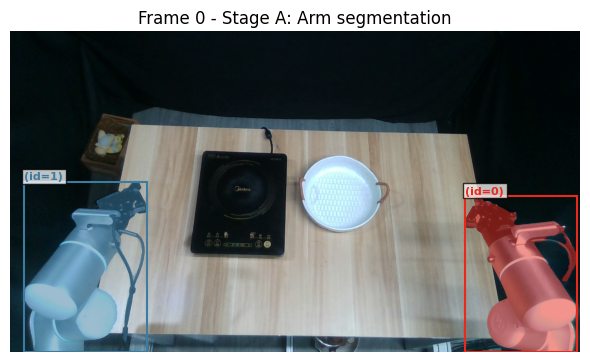

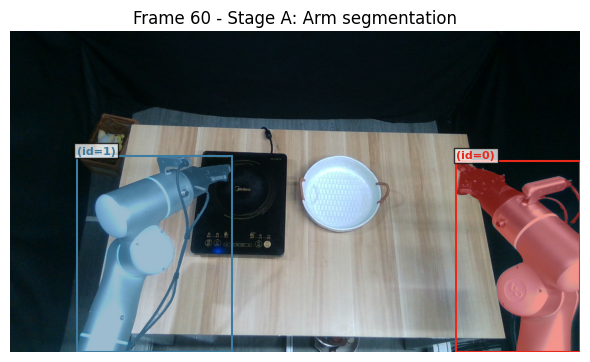

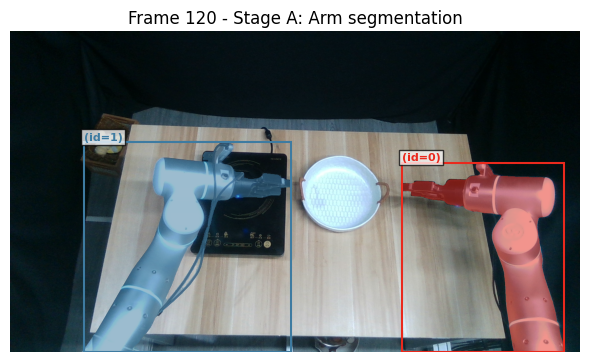

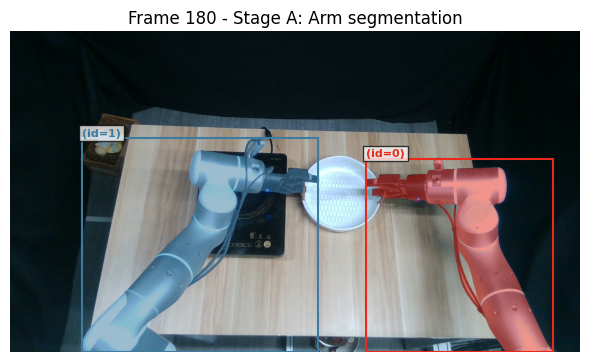

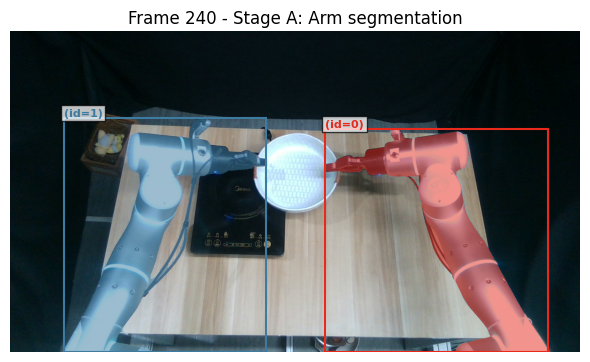

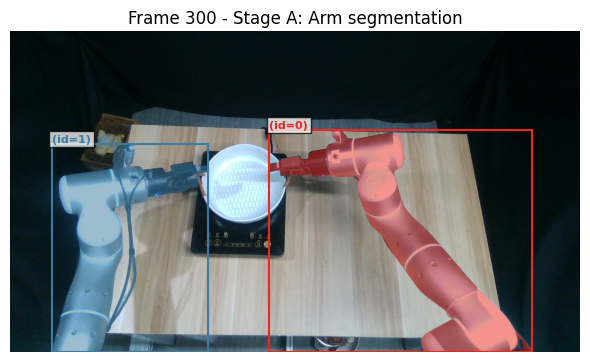

In [5]:
visualize_outputs(
    outputs_per_frame=outputs_stage_a,
    video_frames=video_frames_for_vis,
    stride=VIS_FRAME_STRIDE,
    max_plots=VIS_MAX_PLOTS,
    title="Stage A: Arm segmentation",
)

## 3) 阶段 B：关键帧 points 新增 gripper（全新 obj_id）并再次传播

In [6]:
stage_b_points_only_config = bool(STAGE_B_GRIPPER_POINTS_ONLY)
if not stage_b_points_only_config:
    print(
        "[stage B][warn] 检测到 STAGE_B_GRIPPER_POINTS_ONLY=False，但本流程强制 points-only，已自动改为 True。"
    )
stage_b_points_only_mode = True
print(f"[stage B] points-only mode={stage_b_points_only_mode}")


def _collect_non_empty_gripper_text_prompts():
    collected = []

    for key, val in globals().items():
        if "GRIPPER" in str(key).upper() and "TEXT" in str(key).upper():
            if isinstance(val, str) and val.strip():
                collected.append((f"config.{key}", val.strip()))

    export_map = ANNOTATION_EXPORT_PROMPTS if isinstance(globals().get("ANNOTATION_EXPORT_PROMPTS", None), dict) else {}
    for key, val in export_map.items():
        if "GRIPPER" in str(key).upper() and "TEXT" in str(key).upper():
            if isinstance(val, str) and val.strip():
                collected.append((f"annotation_json.{key}", val.strip()))

    return sorted(set(collected))


ignored_gripper_text_prompts = _collect_non_empty_gripper_text_prompts()
if len(ignored_gripper_text_prompts) > 0:
    print("[stage B][warn] gripper 文本提示路径已禁用（points-only）；以下配置将被忽略：")
    for src, txt in ignored_gripper_text_prompts:
        print(f"  - {src}={txt!r}")


def _validate_stage_b_gripper_points_only_inputs(left_prompts, right_prompts):
    hint = (
        "请先在“可视化点标注”cell对 gripper 打点并导出 JSON，"
        "然后读取该 JSON 后再执行 Stage B。"
    )

    if len(left_prompts) == 0 and len(right_prompts) == 0:
        raise ValueError(
            "[stage B][points-only] 左右 gripper 均无有效关键帧 points。" + hint
        )

    def _check_side(prompt_list, side_tag):
        for i, p in enumerate(prompt_list):
            points = p.get("points_rel")
            labels = p.get("labels")
            if not isinstance(points, list) or len(points) == 0:
                raise ValueError(
                    f"[stage B][points-only] {side_tag}[{i}] 缺少非空 points。" + hint
                )
            if not isinstance(labels, list) or len(labels) != len(points):
                raise ValueError(
                    f"[stage B][points-only] {side_tag}[{i}] labels 与 points 长度不匹配。" + hint
                )
            for j, point in enumerate(points):
                if not isinstance(point, (list, tuple)) or len(point) != 2:
                    raise ValueError(
                        f"[stage B][points-only] {side_tag}[{i}] 第{j}个点格式非法，应为 [x, y]。" + hint
                    )
                x, y = float(point[0]), float(point[1])
                if not (0.0 <= x <= 1.0 and 0.0 <= y <= 1.0):
                    raise ValueError(
                        f"[stage B][points-only] {side_tag}[{i}] 第{j}个点越界: ({x}, {y})。" + hint
                    )
                if int(labels[j]) not in {0, 1}:
                    raise ValueError(
                        f"[stage B][points-only] {side_tag}[{i}] 第{j}个标签非法: {labels[j]}。" + hint
                    )

    _check_side(left_prompts, "GRIPPER_LEFT_KEYFRAME_PROMPTS")
    _check_side(right_prompts, "GRIPPER_RIGHT_KEYFRAME_PROMPTS")


def _summarize_gripper_side(side_name, raw_prompts, norm_prompts):
    raw_entries = len(raw_prompts)
    norm_entries = len(norm_prompts)
    raw_points_lengths = []
    for p in raw_prompts:
        if not isinstance(p, dict):
            raw_points_lengths.append(-1)
            continue
        pts = p.get("points", [])
        raw_points_lengths.append(len(pts) if isinstance(pts, list) else -1)
    raw_points = sum(v for v in raw_points_lengths if v >= 0)
    norm_points = sum(len(p.get("points_rel", [])) for p in norm_prompts if isinstance(p, dict))
    pos_points = sum(
        sum(1 for lb in p.get("labels", []) if int(lb) == 1)
        for p in norm_prompts
        if isinstance(p, dict)
    )
    neg_points = sum(
        sum(1 for lb in p.get("labels", []) if int(lb) == 0)
        for p in norm_prompts
        if isinstance(p, dict)
    )
    frames = sorted(
        {
            int(p["frame_index"])
            for p in norm_prompts
            if isinstance(p, dict) and "frame_index" in p
        }
    )
    obj_ids = sorted(
        {
            int(p["obj_id"])
            for p in norm_prompts
            if isinstance(p, dict) and "obj_id" in p
        }
    )
    print(
        f"[stage B][diag][{side_name}] raw_entries={raw_entries} raw_points={raw_points} "
        f"raw_points_lengths={raw_points_lengths} norm_entries={norm_entries} "
        f"valid_points={norm_points} pos_points={pos_points} neg_points={neg_points} "
        f"frames={frames} obj_ids={obj_ids}"
    )
    if raw_entries > 0 and norm_entries == 0:
        print(
            f"[stage B][diag][{side_name}][warn] 原始标注存在但标准化后为空，请检查 frame_index/coord_type/points/labels 合法性。"
        )


def _find_next_available_obj_id(used_ids, start_id=0):
    candidate = max(int(start_id), 0)
    while candidate in used_ids:
        candidate += 1
    return candidate


def _resolve_effective_gripper_obj_ids(stage_a_present_ids, left_obj_id, right_obj_id):
    blocked = {int(x) for x in stage_a_present_ids}
    used = set(blocked)
    effective = {}
    remap = {}

    for side_name, desired_obj_id in (("left", int(left_obj_id)), ("right", int(right_obj_id))):
        if desired_obj_id not in used:
            effective[side_name] = desired_obj_id
            used.add(desired_obj_id)
            continue

        new_obj_id = _find_next_available_obj_id(used, start_id=desired_obj_id + 1)
        effective[side_name] = new_obj_id
        used.add(new_obj_id)
        remap[side_name] = (desired_obj_id, new_obj_id)

    return effective, remap


def _rebind_prompt_obj_id(prompt_list, new_obj_id):
    rebound = []
    for p in prompt_list:
        q = dict(p)
        q["obj_id"] = int(new_obj_id)
        rebound.append(q)
    return rebound


def _print_stage_b_prompt_source_summary():
    source = str(globals().get("ANNOTATION_PROMPTS_SOURCE", "unknown"))
    json_path = globals().get("ANNOTATION_EXPORT_JSON_PATH", None)
    created_at = globals().get("ANNOTATION_PROMPTS_CREATED_AT_UTC", None)
    left_raw = (
        GRIPPER_LEFT_KEYFRAME_PROMPTS
        if isinstance(GRIPPER_LEFT_KEYFRAME_PROMPTS, list)
        else []
    )
    right_raw = (
        GRIPPER_RIGHT_KEYFRAME_PROMPTS
        if isinstance(GRIPPER_RIGHT_KEYFRAME_PROMPTS, list)
        else []
    )

    def _raw_lengths(prompt_list):
        lengths = []
        for p in prompt_list:
            if not isinstance(p, dict):
                lengths.append(-1)
                continue
            pts = p.get("points", [])
            lengths.append(len(pts) if isinstance(pts, list) else -1)
        return lengths

    print(
        f"[stage B][source] source={source} json_path={json_path} created_at_utc={created_at}"
    )
    print(
        f"[stage B][source][left] raw_entries={len(left_raw)} raw_points_lengths={_raw_lengths(left_raw)}"
    )
    print(
        f"[stage B][source][right] raw_entries={len(right_raw)} raw_points_lengths={_raw_lengths(right_raw)}"
    )


_print_stage_b_prompt_source_summary()

if str(globals().get("ANNOTATION_PROMPTS_SOURCE", "")) != "json":
    raise RuntimeError(
        "[stage B][fatal] 当前为 JSON-only 模式，但检测到 prompts 来源不是 json。"
        "请先运行初始化 cell 以从 JSON 重新加载后再执行 Stage B。"
    )

_validate_stage_b_gripper_points_only_inputs(
    left_prompts=gripper_left_prompts_norm,
    right_prompts=gripper_right_prompts_norm,
)

_summarize_gripper_side(
    side_name="left",
    raw_prompts=GRIPPER_LEFT_KEYFRAME_PROMPTS,
    norm_prompts=gripper_left_prompts_norm,
)
_summarize_gripper_side(
    side_name="right",
    raw_prompts=GRIPPER_RIGHT_KEYFRAME_PROMPTS,
    norm_prompts=gripper_right_prompts_norm,
)

stage_b_spatial_side_diag = diagnose_gripper_prompt_side_consistency(
    left_prompts=gripper_left_prompts_norm,
    right_prompts=gripper_right_prompts_norm,
    img_w=IMG_WIDTH,
    stage_name="stage B",
    dominance_ratio=0.6,
)
if stage_b_spatial_side_diag.get("conflict_type") != "none":
    print(
        "[stage B][diag][warn] 检测到左右侧别与空间分布可能不一致。"
        "本流程仅告警不自动修正，请回到标注步骤复核 left/right 选择。"
    )

stage_a_present_obj_ids = collect_present_obj_ids(outputs_stage_a)
print(f"[stage B][diag] stage_a_present_obj_ids={stage_a_present_obj_ids}")

effective_obj_ids, remapped_obj_ids = _resolve_effective_gripper_obj_ids(
    stage_a_present_ids=stage_a_present_obj_ids,
    left_obj_id=gripper_left_obj_id,
    right_obj_id=gripper_right_obj_id,
)
effective_left_obj_id = int(effective_obj_ids["left"])
effective_right_obj_id = int(effective_obj_ids["right"])

if len(remapped_obj_ids) > 0:
    print("[stage B][diag][warn] 检测到 gripper obj_id 与 Stage A 现存对象冲突，已自动重映射：")
    for side_name in sorted(remapped_obj_ids.keys()):
        old_obj_id, new_obj_id = remapped_obj_ids[side_name]
        print(f"  - side={side_name}: {old_obj_id} -> {new_obj_id}")

gripper_left_prompts_inject = (
    _rebind_prompt_obj_id(gripper_left_prompts_norm, effective_left_obj_id)
    if effective_left_obj_id != int(gripper_left_obj_id)
    else list(gripper_left_prompts_norm)
)
gripper_right_prompts_inject = (
    _rebind_prompt_obj_id(gripper_right_prompts_norm, effective_right_obj_id)
    if effective_right_obj_id != int(gripper_right_obj_id)
    else list(gripper_right_prompts_norm)
)

stage_b_new_obj_ids = sorted({effective_left_obj_id, effective_right_obj_id})
stage_b_union_obj_ids = sorted({arm_cable_obj_id, effective_left_obj_id, effective_right_obj_id})
print(f"[stage B] active_obj_ids(new grippers)={stage_b_new_obj_ids}")
print(f"[stage B] expected_obj_ids_after_merge={stage_b_union_obj_ids}")

def _inject_side_prompts(side_name, prompt_list):
    frames = sorted({int(p["frame_index"]) for p in prompt_list})
    obj_ids = sorted({int(p["obj_id"]) for p in prompt_list})
    valid_points = sum(len(p.get("points_rel", [])) for p in prompt_list)
    print(
        f"[stage B][inject][{side_name}] entries={len(prompt_list)} valid_points={valid_points} "
        f"frames={frames} obj_ids={obj_ids}"
    )

    if len(prompt_list) == 0:
        print(f"[stage B][inject][{side_name}][warn] 无标注点，跳过该侧注入。")
        return

    apply_prompt_list(
        predictor_obj=predictor,
        session_id_value=session_id,
        prompt_list=prompt_list,
        stage_name=f"stage B/{side_name}",
    )


_inject_side_prompts("left", gripper_left_prompts_inject)
_inject_side_prompts("right", gripper_right_prompts_inject)

print("[stage B] propagating bidirectional (forward + backward) ...")
outputs_stage_b = propagate_bidirectional_and_merge(
    predictor_obj=predictor,
    session_id_value=session_id,
    stage_name="stage B",
)
print(f"[stage B] done, merged frame outputs={len(outputs_stage_b)}")

obj_id_samples = sample_obj_ids_from_outputs(outputs_stage_b, max_frames=5, max_obj_ids=12)
print("[stage B] parsed obj_id samples (per frame):")
for frame_idx, obj_ids in obj_id_samples:
    print(f"  - frame={frame_idx}: obj_ids={obj_ids}")

present_all_obj_ids = collect_present_obj_ids(outputs_stage_b)
present_left_obj_ids = collect_present_obj_ids(outputs_stage_b, target_obj_ids=[effective_left_obj_id])
present_right_obj_ids = collect_present_obj_ids(outputs_stage_b, target_obj_ids=[effective_right_obj_id])
present_gripper_obj_ids = sorted(set(present_left_obj_ids + present_right_obj_ids))

print(f"[stage B] present_obj_ids(all)={present_all_obj_ids}")
print(
    f"[stage B][diag][present] left={present_left_obj_ids} right={present_right_obj_ids} "
    f"union={present_gripper_obj_ids}"
)

if len(gripper_left_prompts_inject) == 0:
    print("[stage B][diag] left 未提供标注点（输入为空）。")
elif len(present_left_obj_ids) == 0:
    raise ValueError(
        f"[stage B][diag] left 有标注但结果未出现 obj_id={effective_left_obj_id}。"
        f"请检查该侧点位质量/遮挡，或确认自动重映射后的 obj_id 未被后续流程覆盖。"
    )

if len(gripper_right_prompts_inject) == 0:
    print("[stage B][diag] right 未提供标注点（输入为空）。")
elif len(present_right_obj_ids) == 0:
    raise ValueError(
        f"[stage B][diag] right 有标注但结果未出现 obj_id={effective_right_obj_id}。"
        f"请检查该侧点位质量/遮挡，或确认自动重映射后的 obj_id 未被后续流程覆盖。"
    )

if len(present_gripper_obj_ids) == 0:
    raise ValueError(
        "[stage B] 传播结果中未发现 gripper obj_id。"
        "已按 out_obj_ids<->out_binary_masks 对齐方式与字典键回退方式完成解析，"
        "仍无有效 gripper；已阻断导出以避免错误 arm-only 掩码。"
    )


[stage B] points-only mode=True
[stage B][source] source=json json_path=/data/haoxiang/data/airexo2/task_0013/train/scene_0001/cam_105422061350/annotation_prompts_gripper_points.json created_at_utc=2026-02-26T05:23:42.868444+00:00
[stage B][source][left] raw_entries=2 raw_points_lengths=[1, 1]
[stage B][source][right] raw_entries=2 raw_points_lengths=[1, 1]
[stage B][diag][left] raw_entries=2 raw_points=2 raw_points_lengths=[1, 1] norm_entries=2 valid_points=2 pos_points=2 neg_points=0 frames=[0, 120] obj_ids=[2]
[stage B][diag][right] raw_entries=2 raw_points=2 raw_points_lengths=[1, 1] norm_entries=2 valid_points=2 pos_points=2 neg_points=0 frames=[0, 120] obj_ids=[3]
[stage B][diag][spatial][left] entries=2 all_points=2 pos_points=2 basis=positive basis_points=2 x_mean=396.5 x_median=396.5 left_ratio=1.0 right_ratio=0.0 dominant=left
[stage B][diag][spatial][right] entries=2 all_points=2 pos_points=2 basis=positive basis_points=2 x_mean=1022.0 x_median=1022.0 left_ratio=0.0 right_ra

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

100%|██████████| 353/353 [00:17<00:00, 20.25it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]

[stage B] propagation summary | forward_frames=353 backward_frames=0 merged_frames=353
[stage B] done, merged frame outputs=353
[stage B] parsed obj_id samples (per frame):
  - frame=0: obj_ids=[0, 1, 2, 3]
  - frame=1: obj_ids=[0, 1, 2, 3]
  - frame=2: obj_ids=[0, 1, 2, 3]
  - frame=3: obj_ids=[0, 1, 2, 3]
  - frame=4: obj_ids=[0, 1, 2, 3]
[stage B] present_obj_ids(all)=[0, 1, 2, 3]
[stage B][diag][present] left=[2] right=[3] union=[2, 3]


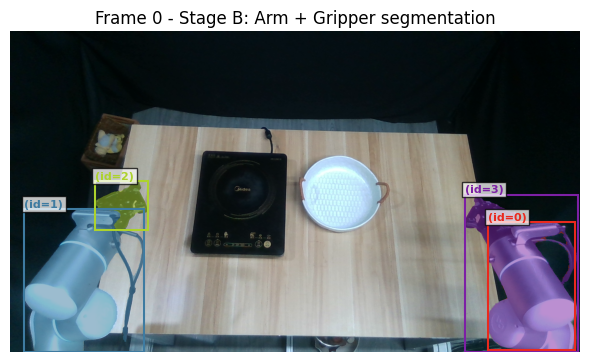

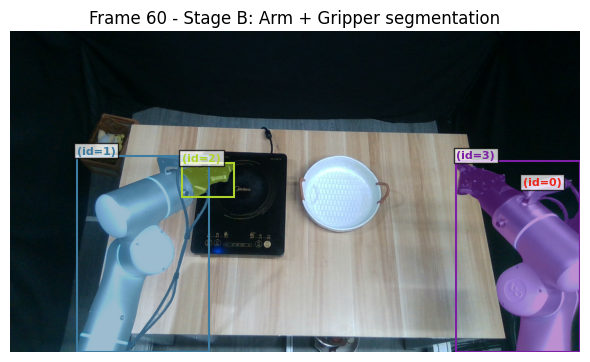

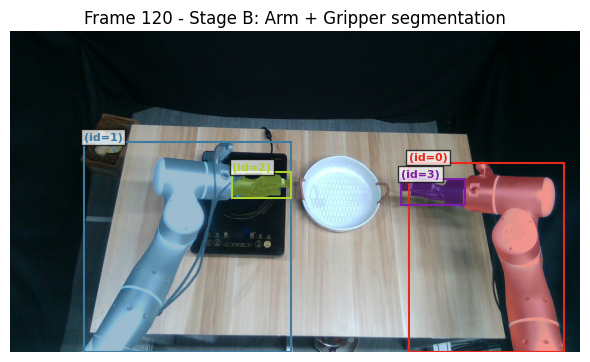

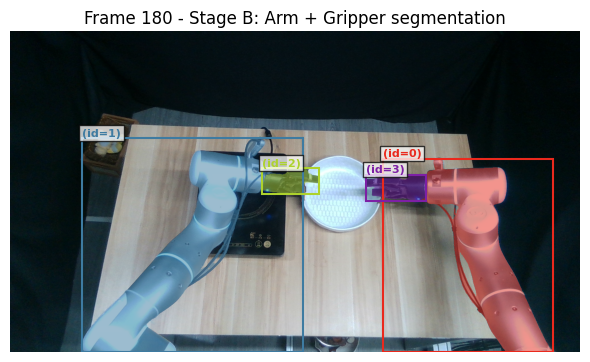

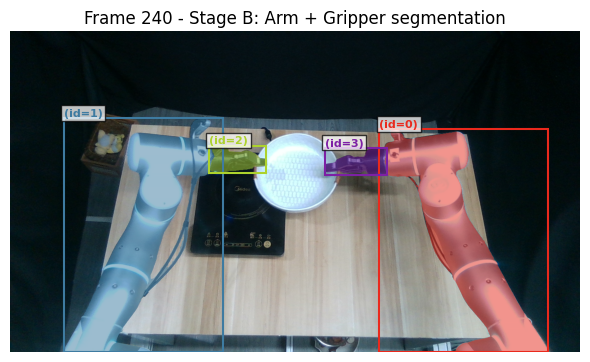

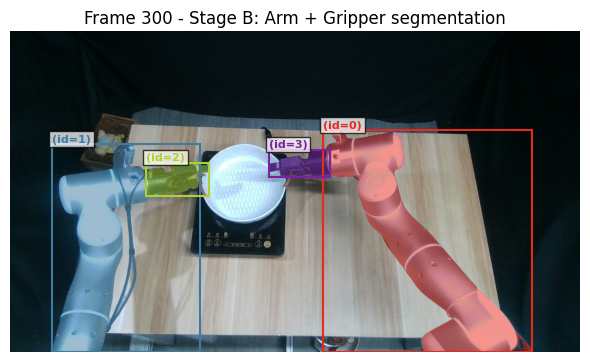

In [7]:
visualize_outputs(
    outputs_per_frame=outputs_stage_b,
    video_frames=video_frames_for_vis,
    stride=VIS_FRAME_STRIDE,
    max_plots=VIS_MAX_PLOTS,
    title="Stage B: Arm + Gripper segmentation",
)

## 4) 导出 mask（固定 arm-only：arm - gripper）

In [ ]:
if outputs_stage_b is None or len(outputs_stage_b) == 0:
    raise ValueError("[export] outputs_stage_b 为空，无法导出 arm-only")

gripper_obj_ids_for_export = [
    int(globals().get("effective_left_obj_id", gripper_left_obj_id)),
    int(globals().get("effective_right_obj_id", gripper_right_obj_id)),
]

print("[export] mode fixed: arm-only subtraction (arm AND NOT gripper)")
print(f"[export] using gripper_obj_ids={gripper_obj_ids_for_export}")

mask_paths = save_arm_only_masks_for_propainter(
    outputs_per_frame=outputs_stage_b,
    video_frames=video_frames_for_vis,
    output_dir=EXPORT_OUTPUT_DIR,
    arm_obj_ids=[arm_cable_obj_id],
    gripper_obj_ids=gripper_obj_ids_for_export,
    dilate_radius=EXPORT_DILATE_RADIUS,
    log_every=EXPORT_LOG_EVERY,
)

print(f"[export] sample: first={mask_paths[0] if mask_paths else 'N/A'}")
print(f"[export] sample: last={mask_paths[-1] if mask_paths else 'N/A'}")


## 5) 资源清理（session close + predictor shutdown + 进程组清理）

In [ ]:
cleanup_resources(
    predictor_obj=predictor,
    session_id_value=session_id,
)

predictor = None
session_id = None
print("[cleanup] globals reset done")